In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!


In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [5]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''

        #     Steps:
        #       1) Do a transposed convolution using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a ReLU activation.
        #       4) If its the final layer, use a Tanh activation after the deconvolution.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE ####
                #### END CODE HERE ####
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride,),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()

            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE ####
                #### END CODE HERE ####
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride,),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

## Discriminator


In [11]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        #     Steps:
        #       1) Add a convolutional layer using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels,output_channels,kernel_size,stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels,output_channels,kernel_size,stride),
                # nn.BatchNorm2d(output_channels),
                # nn.LeakyReLU(0.2)
                #### END CODE HERE ####
            )

    '''
    Function for completing a forward pass of the discriminator: Given an image tensor, 
    returns a 1-dimension tensor representing fake/real.
    Parameters:
        image: a flattened image tensor with dimension (im_dim)
    '''
    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [16]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course!
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,),),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [17]:

gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Step 500: Generator loss: 0.9626806138753893, discriminator loss: 0.4938404636383055


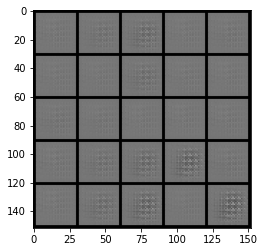

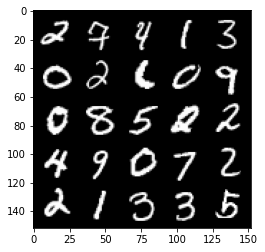

Step 1000: Generator loss: 2.6326633005142206, discriminator loss: 0.12428556552529331


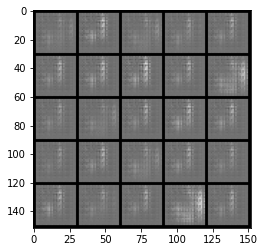

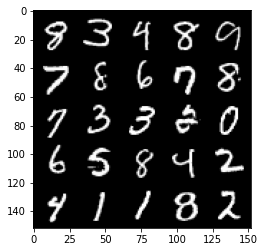

Step 1500: Generator loss: 2.804311130523679, discriminator loss: 0.18558782510086877


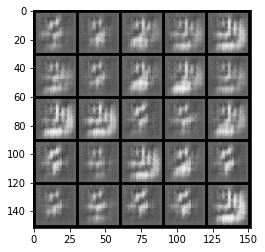

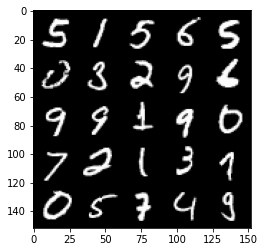

Step 2000: Generator loss: 1.925568883702159, discriminator loss: 0.3244398478940127


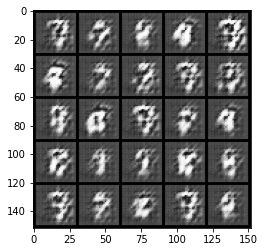

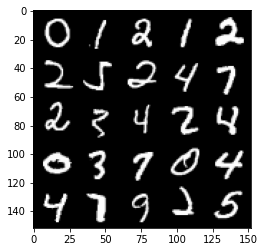

Step 2500: Generator loss: 1.5346023028790963, discriminator loss: 0.4230451960861685


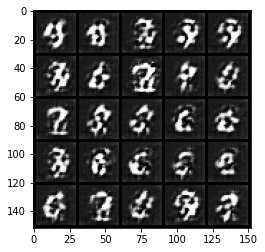

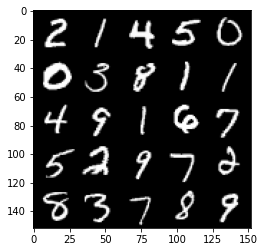

Step 3000: Generator loss: 1.1358769169896836, discriminator loss: 0.5157435269951823


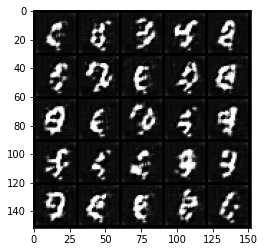

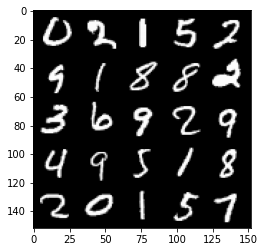

Step 3500: Generator loss: 0.9531108866930015, discriminator loss: 0.5613929662108422


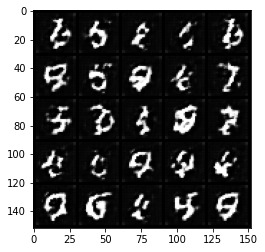

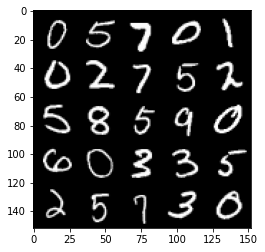

Step 4000: Generator loss: 0.8889809732437134, discriminator loss: 0.6058873653411873


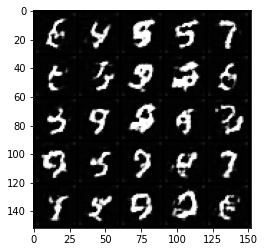

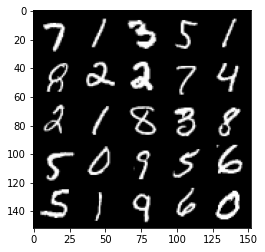

Step 4500: Generator loss: 0.8403361952304844, discriminator loss: 0.6307899036407473


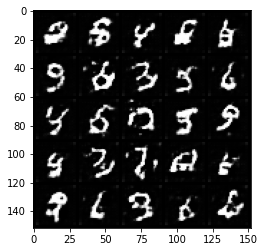

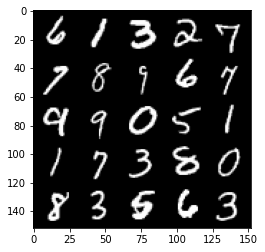

Step 5000: Generator loss: 0.810890589833259, discriminator loss: 0.6437682092189788


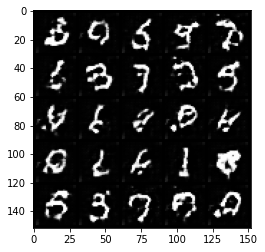

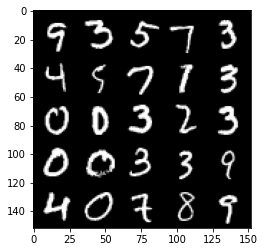

Step 5500: Generator loss: 0.806165703892707, discriminator loss: 0.6536534165143968


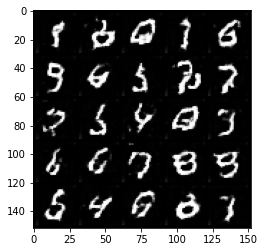

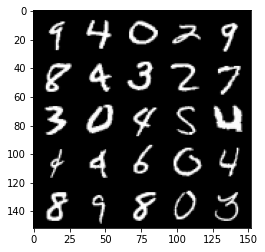

Step 6000: Generator loss: 0.7996280775666242, discriminator loss: 0.6579153394699094


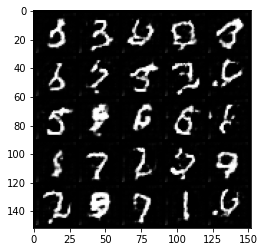

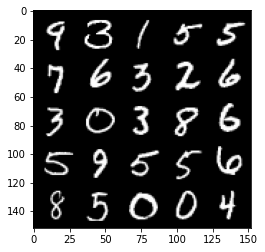

Step 6500: Generator loss: 0.7868143730163571, discriminator loss: 0.6656897069215767


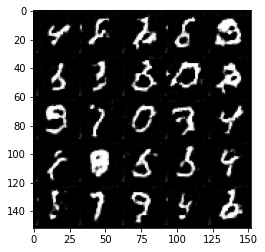

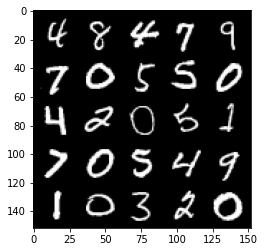

Step 7000: Generator loss: 0.7903757421374314, discriminator loss: 0.6663922588825231


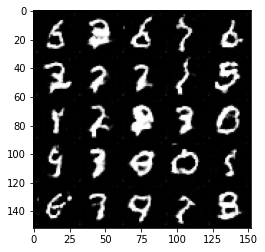

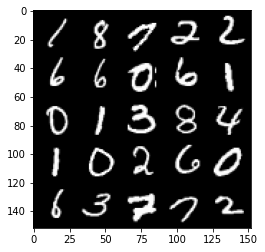

Step 7500: Generator loss: 0.7746840777993202, discriminator loss: 0.6702220386266705


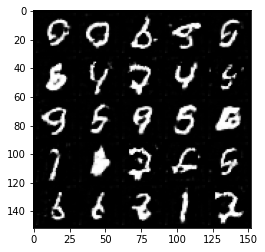

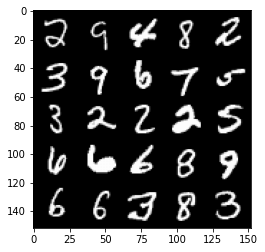

Step 8000: Generator loss: 0.771567964792252, discriminator loss: 0.6741628290414818


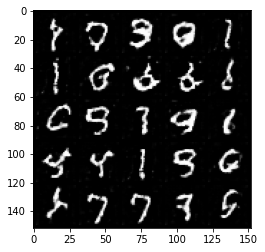

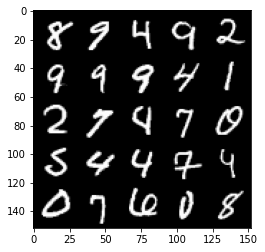

Step 8500: Generator loss: 0.7692523866891865, discriminator loss: 0.6761438009738924


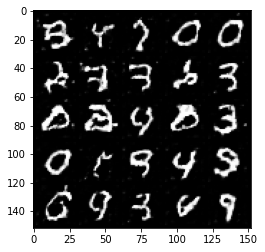

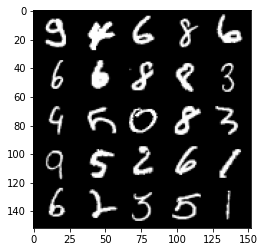

Step 9000: Generator loss: 0.7618001067042359, discriminator loss: 0.6773264753818518


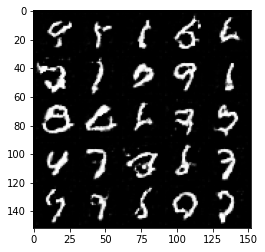

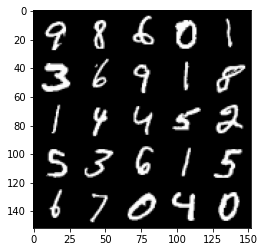

Step 9500: Generator loss: 0.7585401963591581, discriminator loss: 0.6804678416252133


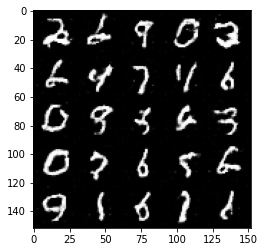

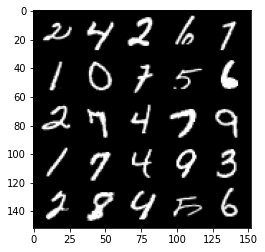

Step 10000: Generator loss: 0.7500951876044281, discriminator loss: 0.683861367464066


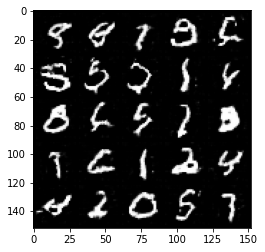

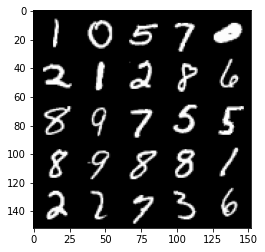

Step 10500: Generator loss: 0.741976310670376, discriminator loss: 0.6870699058771128


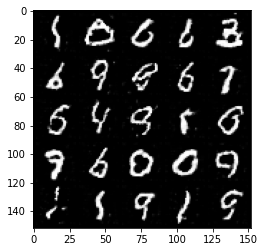

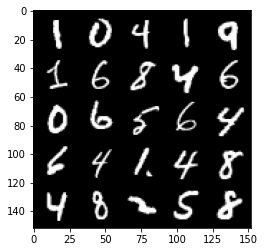

Step 11000: Generator loss: 0.7412975633144371, discriminator loss: 0.6893761107921605


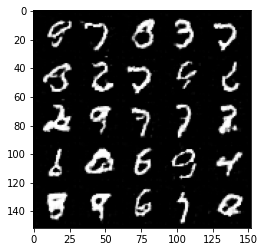

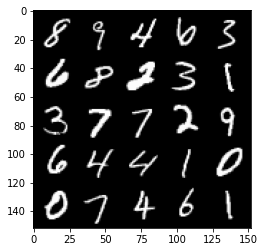

Step 11500: Generator loss: 0.7347404501736166, discriminator loss: 0.6914863804578776


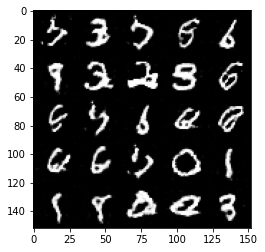

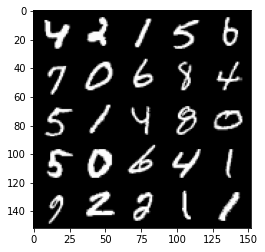

Step 12000: Generator loss: 0.7326982165575032, discriminator loss: 0.6923992414474487


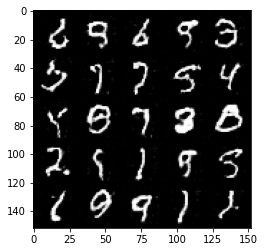

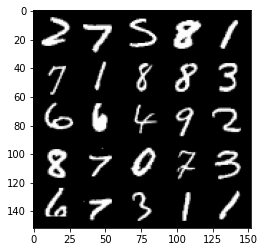

Step 12500: Generator loss: 0.7325097098946571, discriminator loss: 0.692557586550713


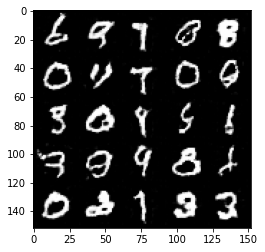

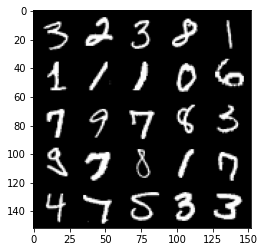

Step 13000: Generator loss: 0.7296673758029936, discriminator loss: 0.6938437401056293


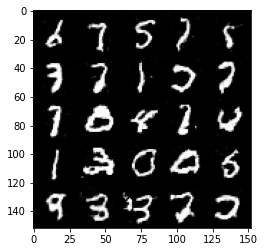

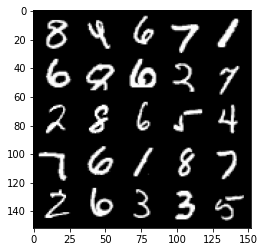

Step 13500: Generator loss: 0.7211522737145426, discriminator loss: 0.6963937931060791


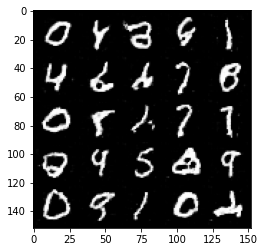

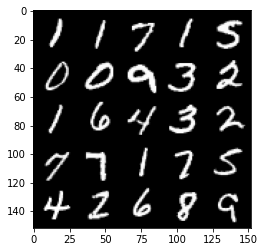

Step 14000: Generator loss: 0.721062308549881, discriminator loss: 0.6974900317192079


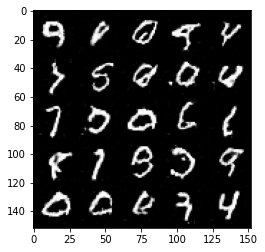

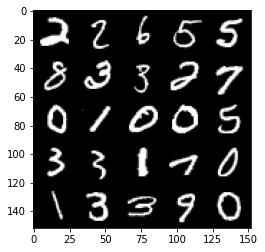

Step 14500: Generator loss: 0.7181177407503129, discriminator loss: 0.696585035800933


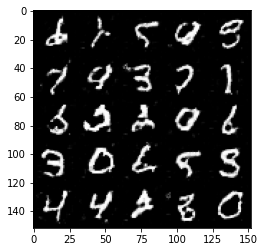

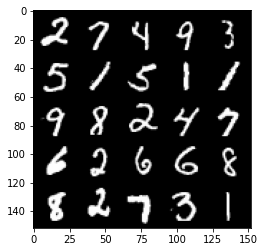

Step 15000: Generator loss: 0.7172530278563498, discriminator loss: 0.6971359766721723


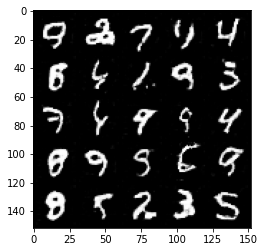

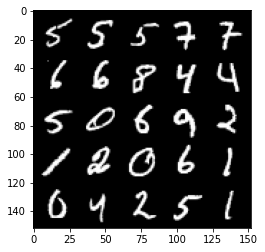

Step 15500: Generator loss: 0.7153077848553657, discriminator loss: 0.6967649059295655


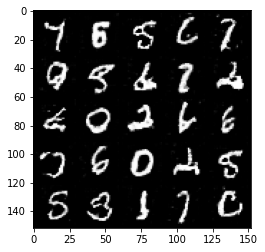

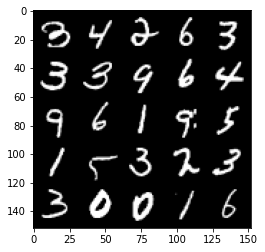

Step 16000: Generator loss: 0.7139305456280715, discriminator loss: 0.6977442561388012


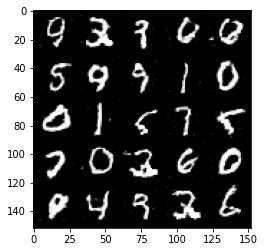

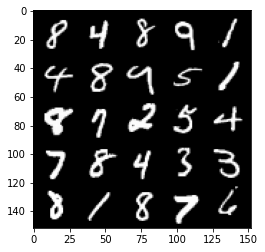

Step 16500: Generator loss: 0.7124160797595972, discriminator loss: 0.6984947037696847


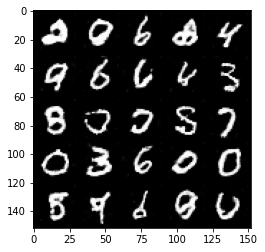

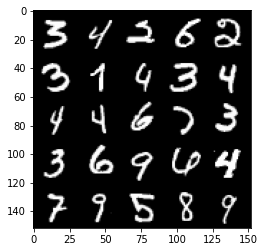

Step 17000: Generator loss: 0.7091417754888539, discriminator loss: 0.6987396030426023


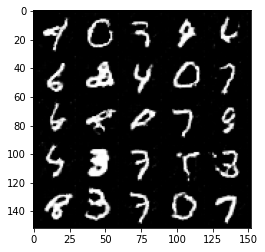

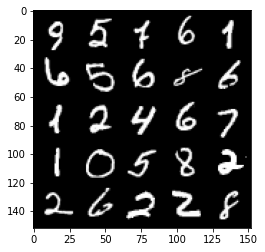

Step 17500: Generator loss: 0.7076387149095534, discriminator loss: 0.6979443725347516


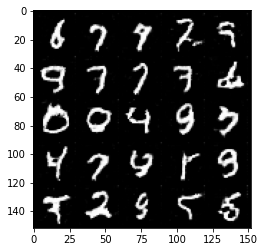

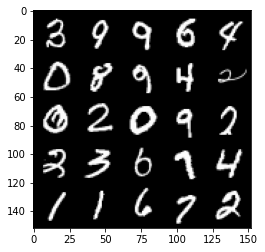

Step 18000: Generator loss: 0.7043271484374996, discriminator loss: 0.6983142039775853


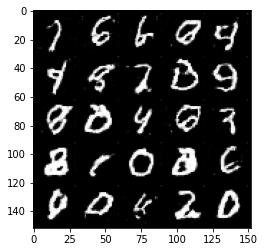

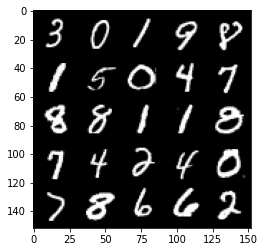

Step 18500: Generator loss: 0.7084055874943734, discriminator loss: 0.6984888304471976


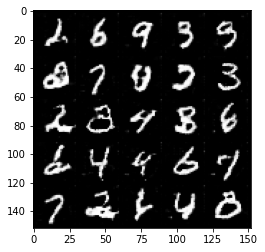

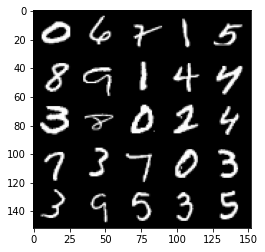

Step 19000: Generator loss: 0.7063222544193268, discriminator loss: 0.698551296710968


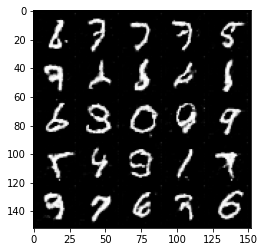

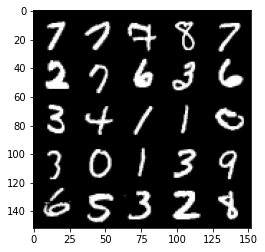

Step 19500: Generator loss: 0.7037912195920948, discriminator loss: 0.698195936560631


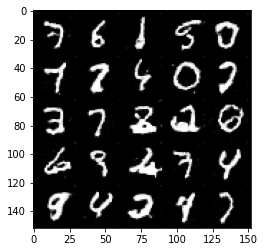

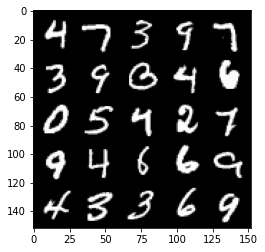

Step 20000: Generator loss: 0.703405240774154, discriminator loss: 0.698439460754394


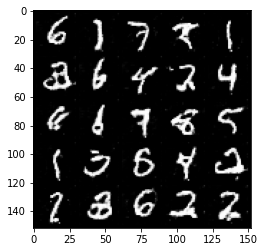

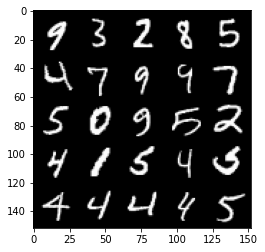

Step 20500: Generator loss: 0.7016311877965928, discriminator loss: 0.6984706872701647


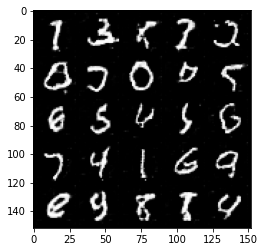

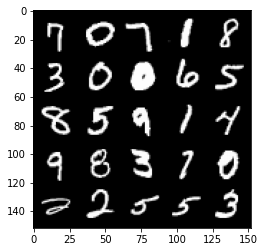

Step 21000: Generator loss: 0.7019908814430234, discriminator loss: 0.698421712756157


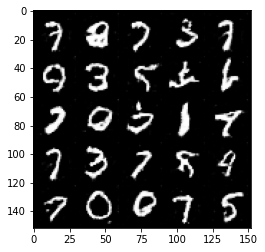

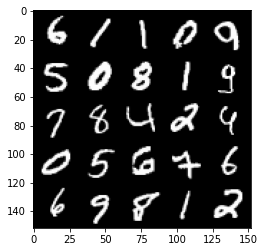

Step 21500: Generator loss: 0.702620694398881, discriminator loss: 0.6978950648307799


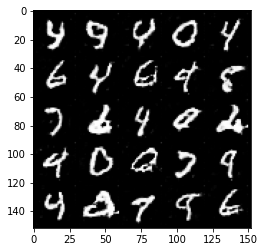

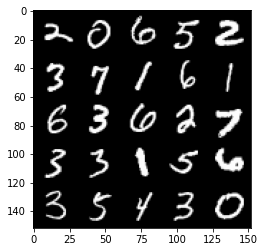

Step 22000: Generator loss: 0.7001015895605088, discriminator loss: 0.698279664516449


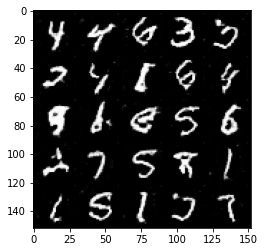

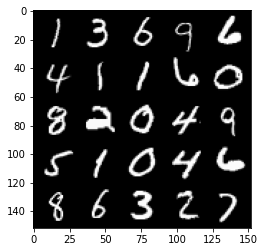

Step 22500: Generator loss: 0.7015444397926331, discriminator loss: 0.6978081792593002


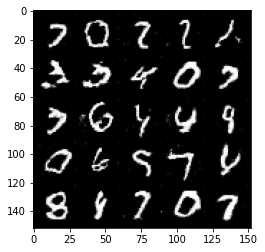

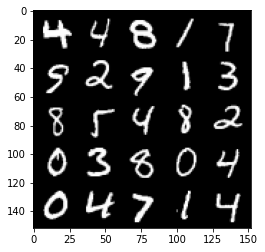

Step 23000: Generator loss: 0.7008541214466093, discriminator loss: 0.697930543541908


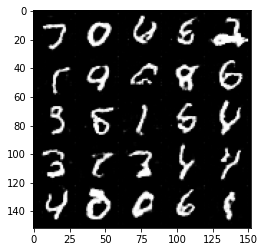

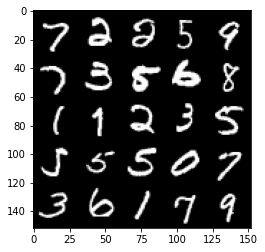

In [18]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1